# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import configuration as config

/mnt/arkk/llm_detector/classifier


In [2]:
# Load the raw training data
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA_PR_TFIDF)

data_df.info()
print()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 92273 entries, 0 to 92272
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 92273 non-null  int64  
 1   Dataset                                  92273 non-null  object 
 2   Source                                   92273 non-null  object 
 3   String                                   92273 non-null  object 
 4   Perplexity                               92273 non-null  float64
 5   Cross-perplexity                         92273 non-null  float64
 6   Perplexity ratio score                   92273 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  92215 non-null  float64
 8   Human TF-IDF                             92273 non-null  float64
 9   Synthetic TF-IDF                         92273 non-null  float64
 10  TF-IDF score                             92273 non-

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.531733,-4.154520,-3.375011,5.869343,0.023852
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.183807,-4.439004,-3.483652,7.568930,0.021732
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.193546,-4.464970,-3.488189,7.768490,0.021335
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.167622,-4.764929,-3.801451,8.253517,0.020277
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.244715,-4.019600,-3.178213,6.056150,0.023744


In [3]:
# Drop unnecessary columns
data_df.drop(['Dataset', 'String'], axis = 1, inplace = True)

data_df.info()
print()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 92273 entries, 0 to 92272
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 92273 non-null  int64  
 1   Source                                   92273 non-null  object 
 2   Perplexity                               92273 non-null  float64
 3   Cross-perplexity                         92273 non-null  float64
 4   Perplexity ratio score                   92273 non-null  float64
 5   Perplexity ratio Kullback-Leibler score  92215 non-null  float64
 6   Human TF-IDF                             92273 non-null  float64
 7   Synthetic TF-IDF                         92273 non-null  float64
 8   TF-IDF score                             92273 non-null  float64
 9   TF-IDF Kullback-Leibler score            92260 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 7.

,Fragment length (tokens),Source,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,229,human,0.971085,1.146746,0.846818,1.531733,-4.154520,-3.375011,5.869343,0.023852
1,267,human,1.185710,1.238428,0.957431,0.183807,-4.439004,-3.483652,7.568930,0.021732
2,290,human,1.212603,1.270731,0.954256,0.193546,-4.464970,-3.488189,7.768490,0.021335
3,156,human,1.285289,1.332959,0.964237,0.167622,-4.764929,-3.801451,8.253517,0.020277
4,231,human,1.272878,1.475141,0.862886,1.244715,-4.019600,-3.178213,6.056150,0.023744


In [4]:
# Split the data into features and labels
labels = data_df['Source']
features = data_df.drop('Source', axis = 1)

features.head()

,Fragment length (tokens),Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,229,0.971085,1.146746,0.846818,1.531733,-4.154520,-3.375011,5.869343,0.023852
1,267,1.185710,1.238428,0.957431,0.183807,-4.439004,-3.483652,7.568930,0.021732
2,290,1.212603,1.270731,0.954256,0.193546,-4.464970,-3.488189,7.768490,0.021335
3,156,1.285289,1.332959,0.964237,0.167622,-4.764929,-3.801451,8.253517,0.020277
4,231,1.272878,1.475141,0.862886,1.244715,-4.019600,-3.178213,6.056150,0.023744


In [5]:
labels.head()

0    human
1    human
2    human
3    human
4    human
Name: Source, dtype: object

In [6]:
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels)
labels = label_encoder.transform(labels)

In [10]:
labels[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [19]:
# Split into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=0)

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')

Training data: 64591 examples
Test data: 27682 examples


In [8]:
import xgboost
from sklearn.metrics import accuracy_score

# fit model on training data
model = xgboost.XGBClassifier()
model.fit(features_train, labels_train)
print(model)
# make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy: 89.06%



Confusion matrix:
[[19879  1348]
 [ 1681  4774]]
27682

Normalized confusion matrix:
[[0.71812008 0.0486959 ]
 [0.06072538 0.17245864]]



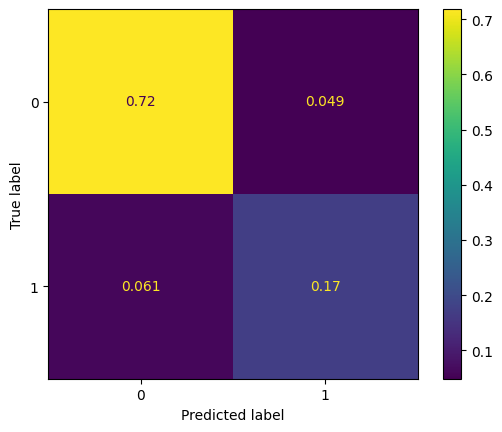

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_test, predictions)

print('\nConfusion matrix:')
print(cm)

print(sum(sum(cm)))
normalized_cm = cm / sum(sum(cm))
print(f'\nNormalized confusion matrix:')
print(normalized_cm)
print()

_ = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test, normalize = 'all')